<a href="https://colab.research.google.com/github/ivancostabernardo/Portfolio/blob/main/2023_10_Income_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INCOME PREDICTION**

# 1. Introduction

## 1.1. Dataset

This dataset, named "adult" and originally from the UCI repository of machine learning databases, can be found on [the website of the Department of Computer Science of the University of Toronto](http://www.cs.toronto.edu/~delve/data/adult/desc.html) as well as on [this Kaggle page](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset).

The explaining variables (features) are:
- `age`: Age of individuals.
- `workclass`: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- `fnlwgt`: Final weight, i.e., number of units in the population that the sample unit represents.
- `education`: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- `education.num`: Number of years of education.
- `marital.status`: Married-civ-spouse, Divorced, Never-married, Separated, - Widowed, Married-spouse-absent, Married-AF-spouse.
- `occupation`: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- `relationship`: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- `race`: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- `sex`: Female, Male.
- `capital.gain`: Income gain from investment.
- `capital.loss`: Income loss from investment.
- `hours.per.week`: Work hours per week.
- `native.country`: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

The target variable is `income`: >50K (more than USD 50 000/year), <=50K (less than or equal to USD 50 000/year). Thus, the main goal in this analysis is to predict whether a new person earns more than USD 50 000/year.

Further documentation is also available on [the website of the University of Toronto](https://www.cs.toronto.edu/~delve/data/adult/adultDetail.html).

## 1.2. Preparation

Mounting Google Drive...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing packages...

In [ ]:
import os
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import ticker
import plotly.express as px
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim.downloader
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts
import random
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

Setting project folder...

In [ ]:
project_folder = '/content/drive/MyDrive/Data science/Projects/2023-10 Income prediction/'

Setting Searborn parameters...

In [ ]:
sns.set_theme()
plot_colors = sns.color_palette('muted')

Reading the CSV file with the data and naming columns...


In [ ]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship',
           'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']

df = pd.read_csv(project_folder + 'adult-dataset.csv', header=None, names=columns)
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# 2. Exploratory analysis

<a name="section-2.1"></a>
## 2.1. Data overview

The `describe` method gives us some general information. For example, the dataset has 48 832 observations. Also, at least 75% of observations have `capital.gain` = 0, and the same amount has `capital.loss` = 0. The apparent "coincidence" among the highest values of the features `capital.gain`, `hours.per.week` and `age`, all of them with "9"s, indicate that the real values might have been capped.


In [ ]:
df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


We create the variable `sample_size` below to store the number of observations in the dataset.

In [ ]:
sample_size = df.shape[0]
sample_size

48842

There are (apparently) no missing values in the data frame, although the missingness might be masked by certain values that indicate the unavailability, such as "?" for categorical variables or specific numbers for quantitative features.

In [ ]:
df.isnull().sum()

age                      0
workclass                0
fnlwgt                   0
education                0
education.num            0
marital.status           0
occupation               0
relationship             0
race                     0
sex                      0
capital.gain             0
capital.loss             0
hours.per.week           0
native.country           0
income                   0
native.country.edited    0
dtype: int64

## 2.2. Income

The chart below shows that 24% of people make more than USD 50K/year.

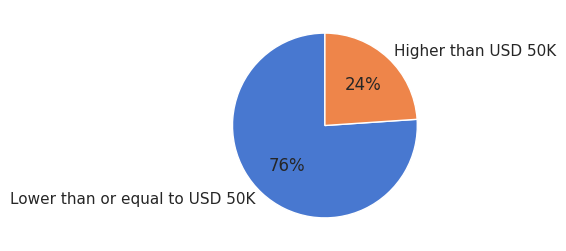

In [ ]:
n_by_income = df['income'].value_counts()
labels_income = {'>50K': 'Higher than USD 50K', '<=50K': 'Lower than or equal to USD 50K'}

plt.figure(figsize=(3, 3))
plt.pie(n_by_income, labels=n_by_income.keys().map(labels_income), colors=plot_colors, autopct='%.0f%%', startangle=90)
plt.show()

We will create a new boolean variable (`income.gtr.50k`) to indicate whether the income is greater than USD 50K/year. The main advantage of it is that it may be directly converted to integer (True = 1, False = 0), which makes calculations easier (for example, the proportion of people who earn more than USD 50K/year is simply the mean of the respective integer values).

Furthermore, in the following text, we will occasionally refer to the two groups as "low income" or "high income".

In [ ]:
df['income.gtr.50k'] = df['income'] == '>50K'

As seen in the pie chart above, approximately 24% of people belong to the "high income" group.

In [ ]:
df['income.gtr.50k'].mean()

0.23928176569346055

## 2.3. Final weight

This is the number of people the census believes the entry represents in the whole population. For simplicity, we will focus solely on the sample and ignore this variable for the rest of the analysis.

## 2.4. Age

As already seen on the table of [section 2.1](#section-2.1), 50% of the sample individuals are less than 37 years old. After that age, frenquencies steadily decrease. Note, however, that the group of 90 year-old people is significantly bigger than any other age above 77. Even though it is, in theory, possible to have such a distribution, the most likely reason for it is the classification of other people under the same label "90".

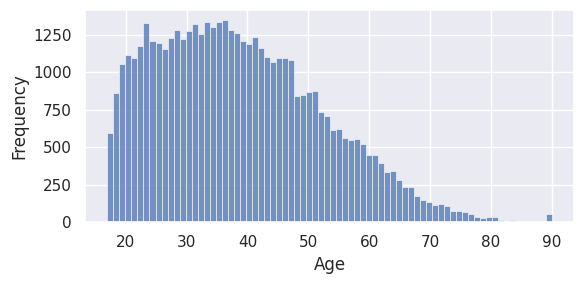

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3))

sns.histplot(data=df, x='age', bins=df['age'].max() - df['age'].min() + 1, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

We do not know if the sample units with `age` = 90 are 90 years or older, have unknown ages or both. For that reason, we will create a dummy variable to signal such occurrences.

In [ ]:
df['age.gtr.eq.90'] = df['age'] >= 90

If we want to know the proportion of high income for each age, we could calculate the average of `income.gtr.50k` grouped by `age`. Nonetheless, the relatively low frequency of some `age` values could cause estimates to oscilate as the age increases. In order to mitigate this, we will group by the individuals into fewer classes by taking into account the nearest multiple of 5 instead of the actual age.

In [ ]:
df['age.mult5'] = (np.round(df['age'] / 5) * 5).astype(int)

As is visible from the chart on the left below, the percentage of high income increases up to age 50 and then begins to fall. Inversely, when we compare the two groups (low income vs. high income), it is clear that people in the second group tend to be older as it exhibits higher values for the age quartiles.

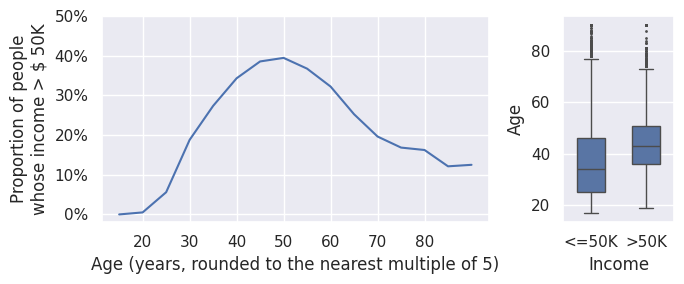

In [ ]:
proportion_income_greater_50k = df[~df['age.gtr.eq.90']].groupby('age.mult5')['income.gtr.50k'].mean().reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(7, 3), width_ratios=[3.5, 1])

sns.lineplot(data=proportion_income_greater_50k, x='age.mult5', y='income.gtr.50k', ax=ax[0])
ax[0].set_xticks(np.arange(20, 90, 10))
ax[0].set_xlabel('Age (years, rounded to the nearest multiple of 5)')
ax[0].set_ylabel('Proportion of people\nwhose income > $ 50K')
y_vals = [tick for tick in ax[0].get_yticks() if tick >= 0]
ax[0].set_yticks(y_vals)
ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))

sns.boxplot(data=df, x='income', y='age', fliersize=1, ax=ax[1], width=0.5)
ax[1].set_xlabel('Income')
ax[1].set_ylabel('Age')

plt.tight_layout()
plt.show()

The behavior of the proportion of high income individuals suggests a quadratic relation between age and probability of high income. Thus we will also create a variable (`age.power.2`) to store the square of the age, so that it will be possible for the machine learning models to take this peculiarity into account.

In [ ]:
df['age.power.2'] = df['age'] ** 2

## 2.5. Work class

Even though the private sector corresponds to the vast majority of workers, its employees are one of the groups with the least proportion of high income. On the other hand, "self-employed, incorporated" and "federal government" are way less common categories, but lead the ranking of high income work classes.

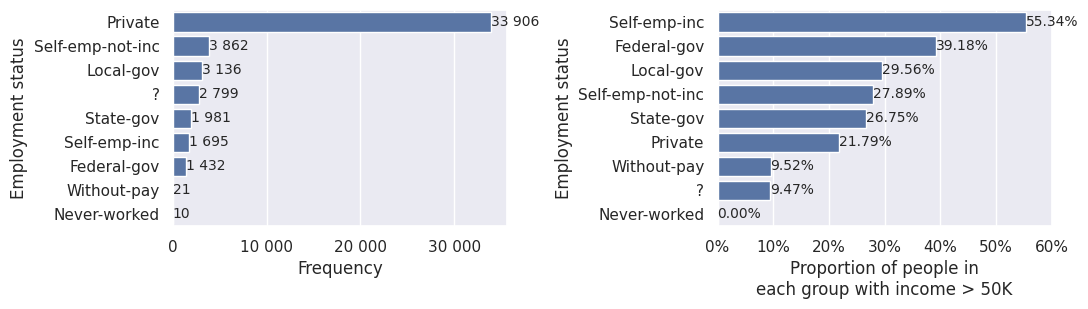

In [ ]:
income_by_workclass = df.groupby('workclass')\
                        .agg({'income.gtr.50k': 'mean', 'workclass': 'count'})\
                        .rename(columns={'workclass': 'count'})\
                        .reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(11, 3.25))

sns.barplot(data=income_by_workclass.sort_values('count', ascending=False), x='count', y='workclass', ax=ax[0])
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Employment status')
ax[0].bar_label(ax[0].containers[0], fmt=lambda x: f'{x:,.0f}'.replace(',', ' '), fontsize=10)
ax[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'.replace(',', ' ')))

sns.barplot(data=income_by_workclass.sort_values('income.gtr.50k', ascending=False),
            x='income.gtr.50k', y='workclass', ax=ax[1])
ax[1].set_xlabel('Proportion of people in\neach group with income > 50K')
ax[1].set_ylabel('Employment status')

ax[1].bar_label(ax[1].containers[0], fmt=lambda x: f'{100*x:.2f}%', fontsize=10)
vals = ax[1].get_xticks()
ax[1].xaxis.set_ticks(vals)
labels_list = ['{:.0%}'.format(x) for x in vals]
ax[1].xaxis.set_ticklabels(labels_list)

plt.tight_layout()
plt.show()

## 2.6. Education

Firstly, let's introduce the meanings of some abbreviations used for educational classification in the dataset that might look confusing for some readers:
- "HS-grad": High School Graduate
- "Prof-school": Professional School (typically postgraduate education for specific professions like law or medicine)
- "Assoc-acdm": Associate's Degree in Academic Programs
- "Assoc-voc": Associate's Degree in Vocational Programs

We see in the chart on the right that less than 8% of people without a high school degree earn more than USD 50K/year, for every subgroup.![Basic_AUC_annotated.png](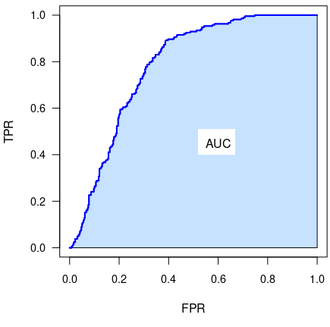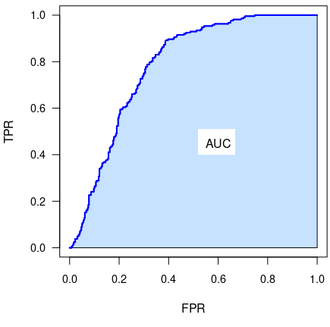) From high school all the way up to doctorate, the leaps between neighbouring groups is much more meaningful, reaching more than 70% for holders of a doctoral degree. We also highlight the professional school group, the one with the highest proportion of high earners and composed by specific professions commonly associated with elevated revenue.

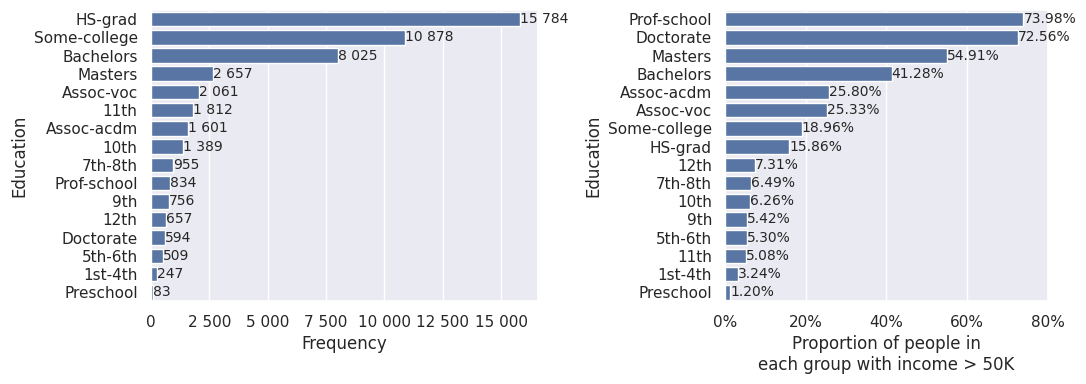

In [ ]:
income_by_education = df.groupby('education')\
                        .agg({'income.gtr.50k': 'mean', 'education': 'count'})\
                        .rename(columns={'education': 'count'})\
                        .reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(11, 4), width_ratios=[1.2, 1])

sns.barplot(data=income_by_education.sort_values('count', ascending=False), x='count', y='education', ax=ax[0])
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Education')
ax[0].bar_label(ax[0].containers[0], fmt=lambda x: f'{x:,.0f}'.replace(',', ' '), fontsize=10)
ax[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'.replace(',', ' ')))

sns.barplot(data=income_by_education.sort_values('income.gtr.50k', ascending=False),
            x='income.gtr.50k', y='education', ax=ax[1])
ax[1].set_xlabel('Proportion of people in\neach group with income > 50K')
ax[1].set_ylabel('Education')

ax[1].bar_label(ax[1].containers[0], fmt=lambda x: f'{100*x:.2f}%', fontsize=10)
vals = ax[1].get_xticks()
ax[1].xaxis.set_ticks(vals)
labels_list = ['{:.0%}'.format(x) for x in vals]
ax[1].xaxis.set_ticklabels(labels_list)

plt.tight_layout()
plt.show()

We see that the percentage of people who make more than USD 50K/year grows exponentially with the years of study.

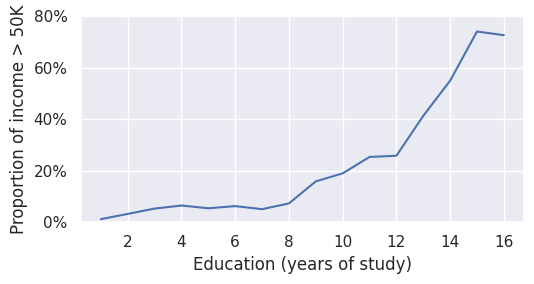

In [ ]:
income_by_education_num = df.groupby('education.num')\
                            .agg({'income.gtr.50k': 'mean', 'education.num': 'count'})\
                            .rename(columns={'education.num': 'count'})\
                            .reset_index()

fig, ax = plt.subplots(figsize=(5.5, 3))

sns.lineplot(data=income_by_education_num.sort_values('income.gtr.50k', ascending=False), x='education.num', y='income.gtr.50k', ax=ax)
ax.set_xlabel('Education (years of study)')
ax.set_ylabel('Proportion of income > 50K')

vals = ax.get_yticks()
ax.yaxis.set_ticks(vals)
ax.set_yticklabels(['{:.0%}'.format(x) for x in vals])
ax.set_ylim(0, 0.8)

plt.tight_layout()
plt.show()

 Based on the finding above, we will create a variable that corresponds to the exponential of the years of study.

In [ ]:
df['education.num.exp'] = np.exp(df['education.num'])

## 2.7. Marital status

We see on the chart on the right that the percentage of married people (except for the case in which the spouse is absent) is significantly higher than that for other marital status categories.

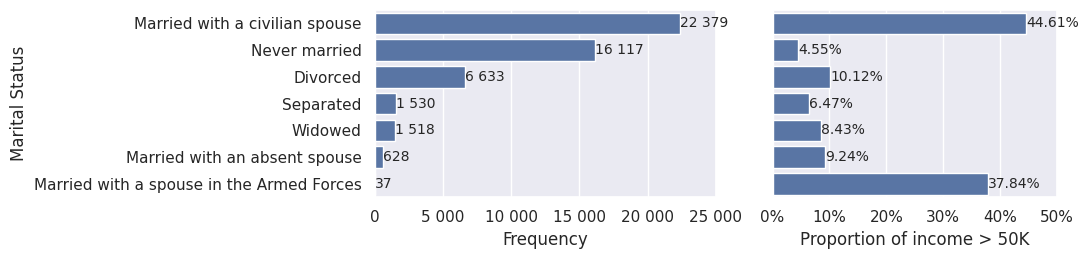

In [ ]:
marital_status_labels = {'Married-civ-spouse': 'Married with a civilian spouse',
                         'Never-married': 'Never married',
                         'Divorced': 'Divorced',
                         'Separated': 'Separated',
                         'Widowed': 'Widowed',
                         'Married-spouse-absent': 'Married with an absent spouse',
                         'Married-AF-spouse': 'Married with a spouse in the Armed Forces'}

income_by_marital_status = df.groupby('marital.status')\
                             .agg({'income.gtr.50k': 'mean', 'marital.status': 'count'})\
                             .rename(columns={'marital.status': 'count'})\
                             .reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(11, 2.75), width_ratios=[1.2, 1], sharey=True)

sns.barplot(data=income_by_marital_status.sort_values('count', ascending=False), x='count', y='marital.status', ax=ax[0])
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Marital Status')
ax[0].bar_label(ax[0].containers[0], fmt=lambda x: f'{x:,.0f}'.replace(',', ' '), fontsize=10)
y_vals = ax[0].get_yticks()
y_labels = ax[0].get_yticklabels()
ax[0].yaxis.set_ticks(y_vals)
ax[0].set_yticklabels([marital_status_labels[y_label.get_text()] for y_label in y_labels])
x_vals = ax[0].get_xticks()
ax[0].xaxis.set_ticks(x_vals)
ax[0].set_xticklabels([f'{x:,.0f}'.replace(',', ' ') for x in x_vals])

sns.barplot(data=income_by_marital_status.sort_values('income.gtr.50k', ascending=False), x='income.gtr.50k', y='marital.status', ax=ax[1])
ax[1].set_xlabel('Proportion of income > 50K')
ax[1].set_ylabel('Marital status')

ax[1].bar_label(ax[1].containers[0], fmt=lambda x: f'{100*x:.2f}%', fontsize=10)
x_vals = ax[1].get_xticks()
ax[1].xaxis.set_ticks(x_vals)
ax[1].set_xticklabels(['{:.0%}'.format(x) for x in x_vals])

plt.tight_layout()
plt.show()

Even though there is a clear relation between marital status and the proportion of people whose income is greater than USD 50K/year, we must not overlook the fact that marital status has a well-known dependence with age, as shown in the plot below. Thus, some of the effect of age on income may be attributable to marital status instead.

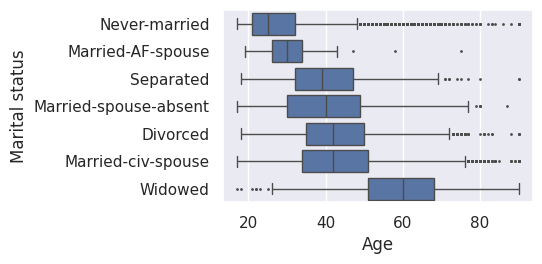

In [ ]:
fig, ax = plt.subplots(figsize=(4, 2.5))

age_by_marital_status = df.groupby('marital.status')['age'].median().sort_values()

sns.boxplot(data=df, x='age', y='marital.status', order=age_by_marital_status.index, fliersize=1)
ax.set_xlabel('Age')
ax.set_ylabel('Marital status')

plt.show()

That is what we see in the chart below, in which the effect of age on the probability of income greater than USD 50K/year is much more subtle in the group of never married people than overall.

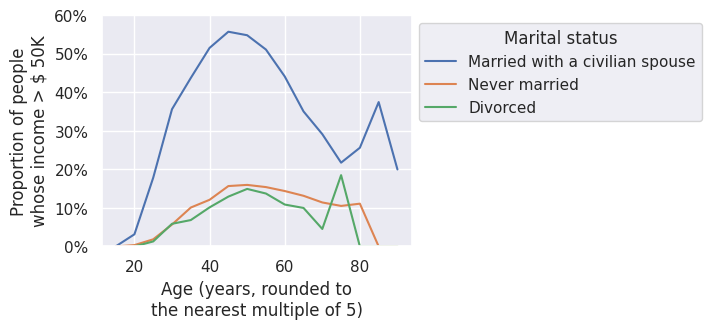

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3), sharey=True)

proportion_income_greater_50k = df[~df['age.gtr.eq.90']].groupby(['age.mult5', 'marital.status'])['income.gtr.50k'].mean().reset_index()
proportion_income_greater_50k['marital.status.labels'] = proportion_income_greater_50k['marital.status'].map(marital_status_labels)

sns.lineplot(data=proportion_income_greater_50k[proportion_income_greater_50k['marital.status']\
                                                .isin(['Married-civ-spouse', 'Never-married', 'Divorced'])],
             x='age.mult5', y='income.gtr.50k', hue='marital.status.labels')
ax.set_xlabel('Age (years, rounded to\nthe nearest multiple of 5)')
ax.set_ylabel('Proportion of people\nwhose income > $ 50K')
vals = ax.get_yticks()
ax.yaxis.set_ticks(vals)
ax.set_yticklabels(['{:.0%}'.format(x) for x in vals])
ax.set_ylim(0, 0.6)
ax.legend(title='Marital status', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Due to cultural and legal issues, there is also an interaction between marital status and sex with respect to the income. For instance, the proportions of men and women married with civilians who make more than USD 50k/year are very close to each other, whereas for other groups we can see a clear distinction between sexes, be it in favour of women (married with spouse in the Armed Forces) or men (other categories).

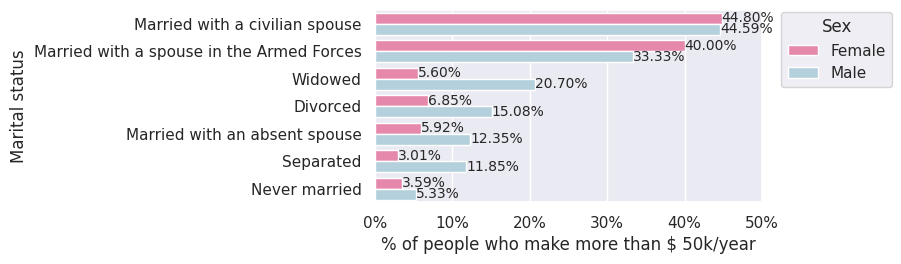

In [ ]:
income_gtr_50k_by_sex_marital_status = df.groupby(['sex', 'marital.status'])['income.gtr.50k']\
                                         .mean()\
                                         .sort_values(ascending=False)\
                                         .reset_index()
income_gtr_50k_by_sex_marital_status['marital.status.labels'] = income_gtr_50k_by_sex_marital_status['marital.status'].map(marital_status_labels)

fig, ax = plt.subplots(figsize=(5, 2.5))

sns.barplot(data=income_gtr_50k_by_sex_marital_status, y='marital.status.labels', x='income.gtr.50k', hue='sex', palette=['#f678a7', '#add2e4'])
ax.bar_label(ax.containers[0], fmt=lambda x: f'{100*x:.2f}%', fontsize=10)
ax.bar_label(ax.containers[1], fmt=lambda x: f'{100*x:.2f}%', fontsize=10)
vals = ax.get_xticks()
ax.xaxis.set_ticks(vals)
ax.set_xticklabels(['{:.0%}'.format(x) for x in vals])
ax.set_xlabel('% of people who make more than $ 50k/year')
ax.set_ylabel('Marital status')

ax.legend(title='Sex', loc='upper left', bbox_to_anchor=(1.03, 1.03))

plt.show()

## 2.8. Relationship

These are the possible values for the `relationship` feature:

In [ ]:
df['relationship'].unique()

array(['Not-in-family', 'Husband', 'Wife', 'Own-child', 'Unmarried',
       'Other-relative'], dtype=object)

We don't need the distinction between "husband" and "wife" as the only difference is each one's sex, which is already another feature. Thus we will combine them into the unique value `Married`.

In [ ]:
df['relationship.edited'] = df['relationship'].replace({'Husband': 'Married', 'Wife': 'Married'})

The plot to the right reveals that 45% of married people earn more than USD 50K annualy. The distant second place is "not in family", with 10%.

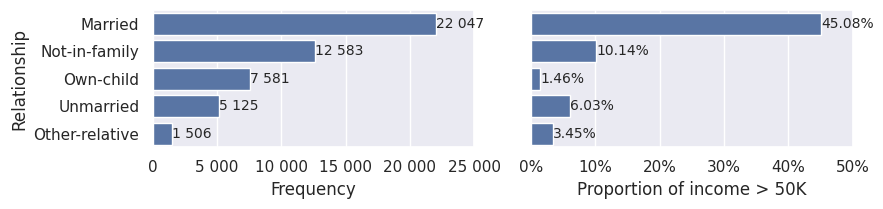

In [ ]:
income_by_relationship = df.groupby('relationship.edited')\
                           .agg({'income.gtr.50k': 'mean', 'relationship.edited': 'count'})\
                           .rename(columns={'relationship.edited': 'count'})\
                           .reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(9, 2.25), sharey=True)

sns.barplot(data=income_by_relationship.sort_values('count', ascending=False),
            x='count', y='relationship.edited', ax=ax[0])
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Relationship')
ax[0].bar_label(ax[0].containers[0], fmt=lambda x: f'{x:,.0f}'.replace(',', ' '), fontsize=10)
vals = ax[0].get_xticks()
ax[0].set_xticks(vals)
ax[0].set_xticklabels([f'{x:,.0f}'.replace(',', ' ') for x in vals])

sns.barplot(data=income_by_relationship.sort_values('income.gtr.50k', ascending=False),
            x='income.gtr.50k', y='relationship.edited', ax=ax[1])
ax[1].set_xlabel('Proportion of income > 50K')
ax[1].set_ylabel('Relationship')

ax[1].bar_label(ax[1].containers[0], fmt=lambda x: f'{100*x:.2f}%', fontsize=10)
vals = ax[1].get_xticks()
ax[1].set_xticks(vals)
ax[1].set_xticklabels(['{:.0%}'.format(x) for x in vals])

plt.tight_layout()
plt.show()

## 2.9. Occupation

The most frequent occupational categories in the sample are professional specialists, craftspeople and repairers, and executive managers. Specialists and executives are also on the top 3 occupations with highest proportions of income > USD 50k/year, but together with Armed Forces workers, who happen to be the least common category of the sample.

Private house service workers, as well as handlers  and cleaners, are among the occupations with the lowest proportions of people whose income is greater than USD 50k/year.

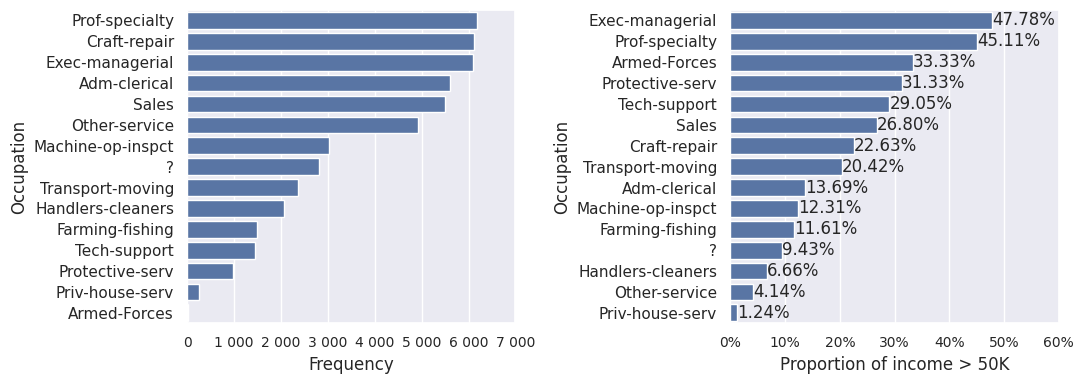

In [ ]:
income_by_occupation = df.groupby('occupation')\
                        .agg({'income.gtr.50k': 'mean', 'occupation': 'count'})\
                        .rename(columns={'occupation': 'count'})\
                        .reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(11, 4))

sns.barplot(data=income_by_occupation.sort_values('count', ascending=False), x='count', y='occupation', ax=ax[0])
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Occupation')
vals = ax[0].get_xticks()
ax[0].set_xticks(vals, labels=vals, fontsize=10)
ax[0].set_xticklabels([f'{x:,.0f}'.replace(',', ' ') for x in vals])

sns.barplot(data=income_by_occupation.sort_values('income.gtr.50k', ascending=False), x='income.gtr.50k', y='occupation', ax=ax[1])
ax[1].set_xlabel('Proportion of income > 50K')
ax[1].set_ylabel('Occupation')


ax[1].bar_label(ax[1].containers[0], fmt=lambda x: f'{100*x:.2f}%')
vals = ax[1].get_xticks()
ax[1].set_xticks(vals, labels=vals, fontsize=10)
ax[1].set_xticklabels(['{:.0%}'.format(x) for x in vals])

plt.tight_layout()
plt.show()

## 2.10. Race

The chart to the right highlights the difference of high income proportion between whites and Asian-Pacific islanders in comparison with American Indigenous and Eskimo communities. The ratio of proportions is roughly 2 (for the former two groups) to 1 (for the latter ones).

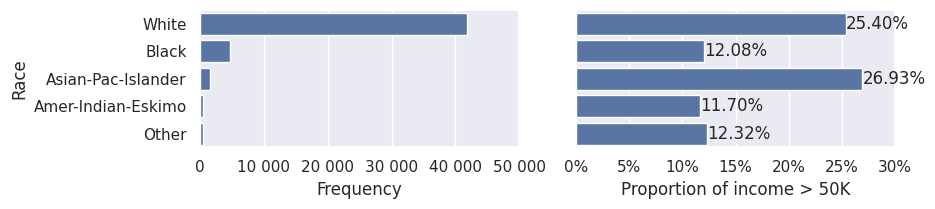

In [ ]:
income_by_race = df.groupby('race')\
                   .agg({'income.gtr.50k': 'mean', 'race': 'count'})\
                   .rename(columns={'race': 'count'})\
                   .reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(9.5, 2.25), sharey=True)

sns.barplot(data=income_by_race.sort_values('count', ascending=False), x='count', y='race', ax=ax[0])
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Race')
vals = ax[0].get_xticks()
ax[0].set_xticks(vals)
ax[0].set_xticklabels([f'{x:,.0f}'.replace(',', ' ') for x in vals])

sns.barplot(data=income_by_race.sort_values('income.gtr.50k', ascending=False), x='income.gtr.50k', y='race', ax=ax[1])
ax[1].set_xlabel('Proportion of income > 50K')
ax[1].set_ylabel('Race')


ax[1].bar_label(ax[1].containers[0], fmt=lambda x: f'{100*x:.2f}%')
vals = ax[1].get_xticks()
ax[1].set_xticks(vals)
ax[1].set_xticklabels(['{:.0%}'.format(x) for x in vals])

plt.tight_layout()
plt.show()

## 2.11. Sex

The graph below portrays a notable difference between sexes when it comes to income. The proportion of men whose income is greater than USD 50K/year is roughly three times the respective value for women.

In [ ]:
income_by_sex = df.groupby('sex')\
                  .agg({'income.gtr.50k': 'mean', 'sex': 'count'})\
                  .rename(columns={'sex': 'count'})\
                  .reset_index()
income_by_sex

,sex,income.gtr.50k,count
0,Female,0.109251,16192
1,Male,0.303767,32650


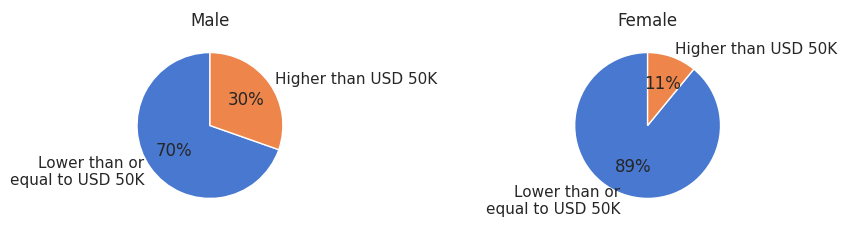

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(8, 3))

n_by_income_male = df.query('sex == "Male"')['income'].value_counts()
n_by_income_female = df.query('sex == "Female"')['income'].value_counts()
labels_income = {'>50K': 'Higher than USD 50K', '<=50K': 'Lower than or\nequal to USD 50K'}

ax[0].pie(n_by_income_male, labels=n_by_income_male.keys().map(labels_income),
          colors=plot_colors, autopct='%.0f%%', startangle=90)
ax[0].set_title('Male')
ax[1].axis('off')
ax[2].pie(n_by_income_female, labels=n_by_income_female.keys().map(labels_income),
          colors=plot_colors, autopct='%.0f%%', startangle=90)
ax[2].set_title('Female')

plt.show()

## 2.12. Capital gain and loss

We see below that almost 92% of individuals in the sample have capital gain equal to zero. Also, there is a relatively large proportion (especially if we consider only records with capital gain > 0) of capital gain = $ 99 999, which is most likely a stand-in for unavailable values. Thus, we will create a variable to indicate such an occurrence.

In [ ]:
df['capital.gain'].value_counts(normalize=True).sort_values(ascending=False)[:10]

0        0.917387
15024    0.010503
7688     0.008394
7298     0.007453
99999    0.004996
3103     0.003112
5178     0.002989
5013     0.002395
4386     0.002211
8614     0.001679
Name: capital.gain, dtype: float64

In [ ]:
df['capital.gain.na'] = df['capital.gain'] == 99999

We also have 95% of records with capital loss equal to zero.

In [ ]:
df['capital.loss'].value_counts(normalize=True).sort_values(ascending=False)[:10]

0       0.953278
1902    0.006224
1977    0.005180
1887    0.004770
2415    0.001474
1485    0.001454
1848    0.001372
1590    0.001269
1602    0.001269
1876    0.001208
Name: capital.loss, dtype: float64

This suggests that we conduct the analysis two-fold: firstly, comparing individuals **with** versus **without** capital gain/loss, and then, for those with positive capital gain/loss values, we analyse the relationship between the proportion of high income and the capital gain/loss amount.

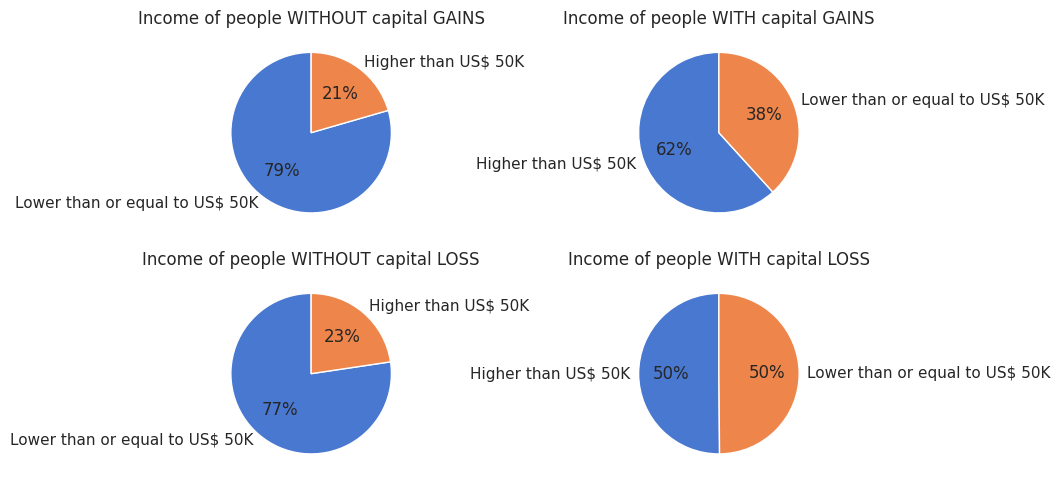

In [ ]:
df['capital.gain.gtr.0'] = df['capital.gain'] > 0
income_capital_gain = df[df['capital.gain.gtr.0']].value_counts('income')
income_no_capital_gain = df[~ df['capital.gain.gtr.0']].value_counts('income')

df['capital.loss.gtr.0'] = df['capital.loss'] > 0
income_capital_loss = df[df['capital.loss.gtr.0']].value_counts('income')
income_no_capital_loss = df[~ df['capital.loss.gtr.0']].value_counts('income')

labels_income = {'>50K': 'Higher than US$ 50K', '<=50K': 'Lower than or equal to US$ 50K'}

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 5))

ax[0, 0].pie(income_no_capital_gain, labels=income_no_capital_gain.keys().map(labels_income), colors=plot_colors, autopct='%.0f%%', startangle=90)
ax[0, 0].set_title('Income of people WITHOUT capital GAINS')
ax[0, 1].pie(income_capital_gain, labels=income_capital_gain.keys().map(labels_income), colors=plot_colors, autopct='%.0f%%', startangle=90)
ax[0, 1].set_title('Income of people WITH capital GAINS')

ax[1, 0].pie(income_no_capital_loss, labels=income_no_capital_loss.keys().map(labels_income), colors=plot_colors, autopct='%.0f%%', startangle=90)
ax[1, 0].set_title('Income of people WITHOUT capital LOSS')
ax[1, 1].pie(income_capital_loss, labels=income_capital_loss.keys().map(labels_income), colors=plot_colors, autopct='%.0f%%', startangle=90)
ax[1, 1].set_title('Income of people WITH capital LOSS')


plt.tight_layout()
plt.show()

We can see below that, even though there is a clear relation between high income and capital gain (or loss), the proportion of high income people does not rise linearly with respect to the other variable. Instead, we can observe an optimal range of capital gain/loss, apart from which the proportion of people whose income is greater than USD 50K/year falls abruptly to zero.

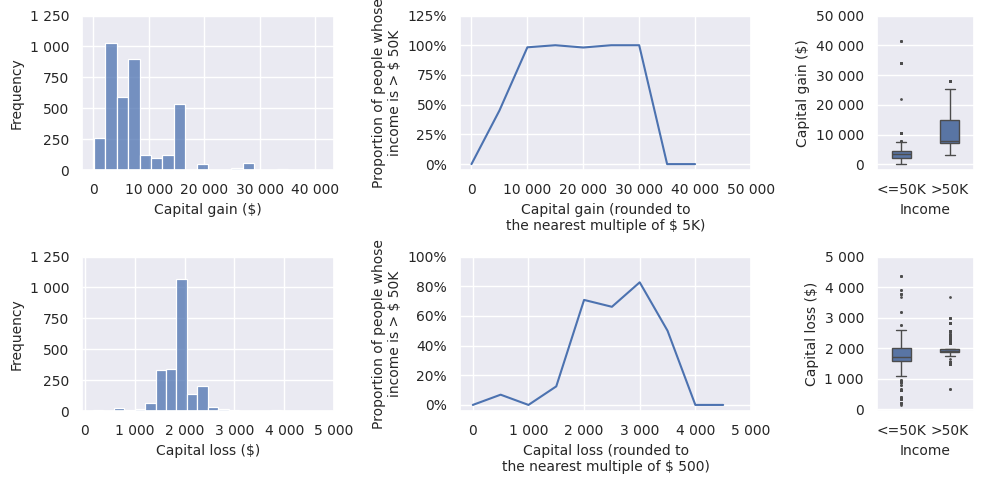

In [ ]:
df_capital_gain_gtr0 = df.loc[(df['capital.gain'] > 0) & (df['capital.gain'] < 99999), ['capital.gain', 'income.gtr.50k']]
df_capital_gain_gtr0['capital.gain.mult.5k'] = (np.round(df_capital_gain_gtr0['capital.gain'] / 5000) * 5000)
proportion_income_greater_50k_gain = df_capital_gain_gtr0.groupby('capital.gain.mult.5k')['income.gtr.50k'].mean()\
                                                         .reset_index()

df_capital_loss_gtr0 = df.loc[df['capital.loss'] > 0, ['capital.loss', 'income.gtr.50k']]
df_capital_loss_gtr0['capital.loss.mult.500'] = (np.round(df_capital_loss_gtr0['capital.loss'] / 500) * 500)
proportion_income_greater_50k_loss = df_capital_loss_gtr0.groupby('capital.loss.mult.500')['income.gtr.50k'].mean()\
                                                         .reset_index()

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10, 5), width_ratios=(13, 15, 5))

sns.histplot(df_capital_gain_gtr0['capital.gain'], bins=20, ax=ax[0, 0])
x_vals = np.arange(0, 50000, 10000)
ax[0, 0].set_xticks(ticks=x_vals, labels=x_vals, fontsize=10)
ax[0, 0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'.replace(',', ' ')))
ax[0, 0].set_xlabel('Capital gain ($)', fontsize=10)
y_vals = ax[0, 0].get_yticks()
ax[0, 0].set_yticks(ticks=y_vals, labels=y_vals, fontsize=10)
ax[0, 0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'.replace(',', ' ')))
ax[0, 0].set_ylabel('Frequency', fontsize=10)

sns.lineplot(data=proportion_income_greater_50k_gain, x='capital.gain.mult.5k', y='income.gtr.50k', ax=ax[0, 1])
ax[0, 1].set_xlabel('Capital gain (rounded to\nthe nearest multiple of $ 5K)', fontsize=10)
x_vals = [tick for tick in ax[0, 1].get_xticks() if tick >= 0]
# ax[0, 1].set_xticks(xticks, labels=xticks, rotation=45, ha='right', rotation_mode='anchor')
ax[0, 1].set_xticks(ticks=x_vals, labels=x_vals, rotation_mode='anchor', fontsize=10)
ax[0, 1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'.replace(',', ' ')))
y_vals = [tick for tick in ax[0, 1].get_yticks() if tick >= 0]
ax[0, 1].set_yticks(ticks=y_vals, labels=y_vals, fontsize=10)
ax[0, 1].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
ax[0, 1].set_ylabel('Proportion of people whose\nincome is > $ 50K', fontsize=10)

sns.boxplot(data=df_capital_gain_gtr0, x='income.gtr.50k', y='capital.gain', fliersize=1, width=0.4, ax=ax[0, 2])
ax[0, 2].set_xticks([1, 0], ['>50K', '<=50K'], fontsize=10)
ax[0, 2].set_xlabel('Income', fontsize=10)
ax[0, 2].set_ylabel('Capital gain ($)', fontsize=10)
y_vals = [tick for tick in ax[0, 2].get_yticks() if tick >= 0]
ax[0, 2].set_yticks(ticks=y_vals, labels=y_vals, fontsize=10)
ax[0, 2].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'.replace(',', ' ')))

sns.histplot(df_capital_loss_gtr0['capital.loss'], bins=20, ax=ax[1, 0])
x_vals = [tick for tick in ax[1, 0].get_xticks() if tick >= 0]
ax[1, 0].set_xticks(x_vals, labels=x_vals, fontsize=10)
ax[1, 0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'.replace(',', ' ')))
ax[1, 0].set_xlabel('Capital loss ($)', fontsize=10)
y_vals = [tick for tick in ax[1, 0].get_yticks() if tick >= 0]
ax[1, 0].set_yticks(y_vals, labels=y_vals, fontsize=10)
ax[1, 0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'.replace(',', ' ')))
ax[1, 0].set_ylabel('Frequency', fontsize=10)

sns.lineplot(data=proportion_income_greater_50k_loss, x='capital.loss.mult.500', y='income.gtr.50k', ax=ax[1, 1])
ax[1, 1].set_xlabel('Capital loss (rounded to\nthe nearest multiple of $ 500)', fontsize=10)
ax[1, 1].set_ylabel('Proportion of people whose\nincome is > $ 50K', fontsize=10)
ax[1, 1].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
x_vals = [tick for tick in ax[1, 1].get_xticks() if tick >= 0]
ax[1, 1].set_xticks(ticks=x_vals, labels=x_vals, rotation_mode='anchor', fontsize=10)
ax[1, 1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'.replace(',', ' ')))
y_vals = [tick for tick in ax[1, 1].get_yticks() if tick >= 0]
ax[1, 1].set_yticks(ticks=y_vals, labels=y_vals, fontsize=10)
ax[1, 1].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))

sns.boxplot(data=df_capital_loss_gtr0, x='income.gtr.50k', y='capital.loss', fliersize=1, width=0.4, ax=ax[1, 2])
ax[1, 2].set_xticks([1, 0], ['>50K', '<=50K'], fontsize=10)
ax[1, 2].set_xlabel('Income', fontsize=10)
ax[1, 2].set_ylabel('Capital loss ($)', fontsize=10)
y_vals = [tick for tick in ax[1, 2].get_yticks() if tick >= 0]
ax[1, 2].set_yticks(ticks=y_vals, labels=y_vals, fontsize=10)
ax[1, 2].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'.replace(',', ' ')))

plt.tight_layout()
plt.show()

The finding above suggests the creation of the following variables, which signal that the capital gain/loss is within the optimal range.

In [ ]:
df['capital.gain.10k..30k'] = (df['capital.gain'] >= 10000) & (df['capital.gain'] <= 30000)
df['capital.loss.2k..3.5k'] = (df['capital.loss'] >= 2000) & (df['capital.loss'] <= 3500)

In [ ]:
df['capital.gain.group'] = np.where(df['capital.gain'] == 0, '0',
                           np.where(df['capital.gain'] < 10000, '0 -- 10000',
                           np.where(df['capital.gain'] <= 30000, '10000 |--| 30000',
                           np.where(df['capital.gain'] < 99999, '30000 --', 'NA'))))

df['capital.loss.group'] = np.where(df['capital.loss'] == 0, '0',
                           np.where(df['capital.loss'] < 2000, '0 -- 2000',
                           np.where(df['capital.loss'] <= 3500, '2000 |--| 3500', '3500 --')))

## 2.13. Hours per week

The first chart below indicates that higher income is associated with more hours of work per week when we compare the quartiles of the sample distribution of weekly hours of both groups. Nonetheless, the chart on the right gives us a more precise notion of the relation between the two variables, with three intervals of hours of work per week:
- from 0 to approximately 15 hours of work per week, the proportion of people whose income is greater than USD 50K/year decreases as the number of hours of work increase;
- from 15 to 55 hours/week, the proportion of high income increases with the hours of work;
- starting at 55 hours/week, the proportion of people with income greater than USD 50K/year drops again.

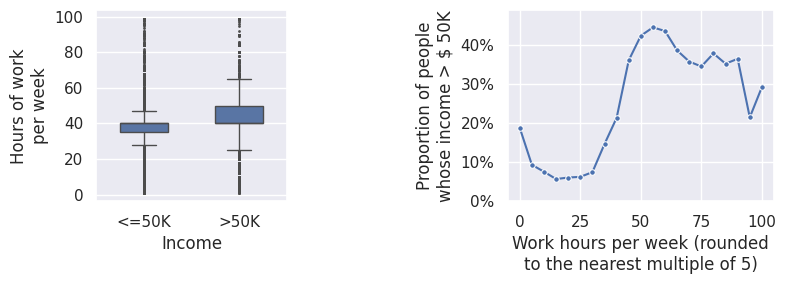

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(8, 3), width_ratios=(1, 0.01, 1.4))

sns.boxplot(data=df, x='income', y='hours.per.week', fliersize=1, ax=ax[0], width=0.5)
ax[0].set_xlabel('Income')
ax[0].set_ylabel('Hours of work\nper week')

df['hours.per.week.mult5'] = round(df['hours.per.week'] / 5) * 5
proportion_income_greater_50k = df.groupby('hours.per.week.mult5')['income.gtr.50k'].mean().reset_index()

ax[1].axis('off')

sns.lineplot(data=proportion_income_greater_50k, x='hours.per.week.mult5', y='income.gtr.50k',
             marker='o', markersize=4, ax=ax[2])
ax[2].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))

ax[2].set_xlabel('Work hours per week (rounded\nto the nearest multiple of 5)')
max_y = proportion_income_greater_50k['income.gtr.50k'].max()
ax[2].set_ylim(0, max_y * 1.1)
ax[2].set_ylabel('Proportion of people\nwhose income > $ 50K')

plt.tight_layout()
plt.show()

Since the line in the chart above resembles a third degree polynomial, let's create the variables below, which correspond to the second and third powers of the feature `hours.per.week`, so that we can use them later on to predict the target variable.

In [ ]:
df['hours.per.week.power.2'] = df['hours.per.week'] ** 2
df['hours.per.week.power.3'] = df['hours.per.week'] ** 3

The three groups that we identified based on the weekly number of work hours may be different as to other variables as well. The following charts depict the relation between hours of work and other features for individuals with income > USD 50K/year. Here are some differences that we can detect:
- the main work class in the group "0 |-- 15 h/week" is unknown ("?"), whereas for the other groups it is "Private";
- the percentage of people in the group " 55 |-- h/week" who attended a professional school (10%) is roughly 2.5 times the respective proportion in the group "15 |-- 55";
- the proportion of men increases jointly with the hours of work;
- the main occupation is unknown ("?") in the group "0 |-- 15 h/week", "professional speacialty" in the group "15 |-- 55 h/week" and "Clerical administration" for "55 |-- h/week".

These remarks indicate interaction between hours of work per week and other features.

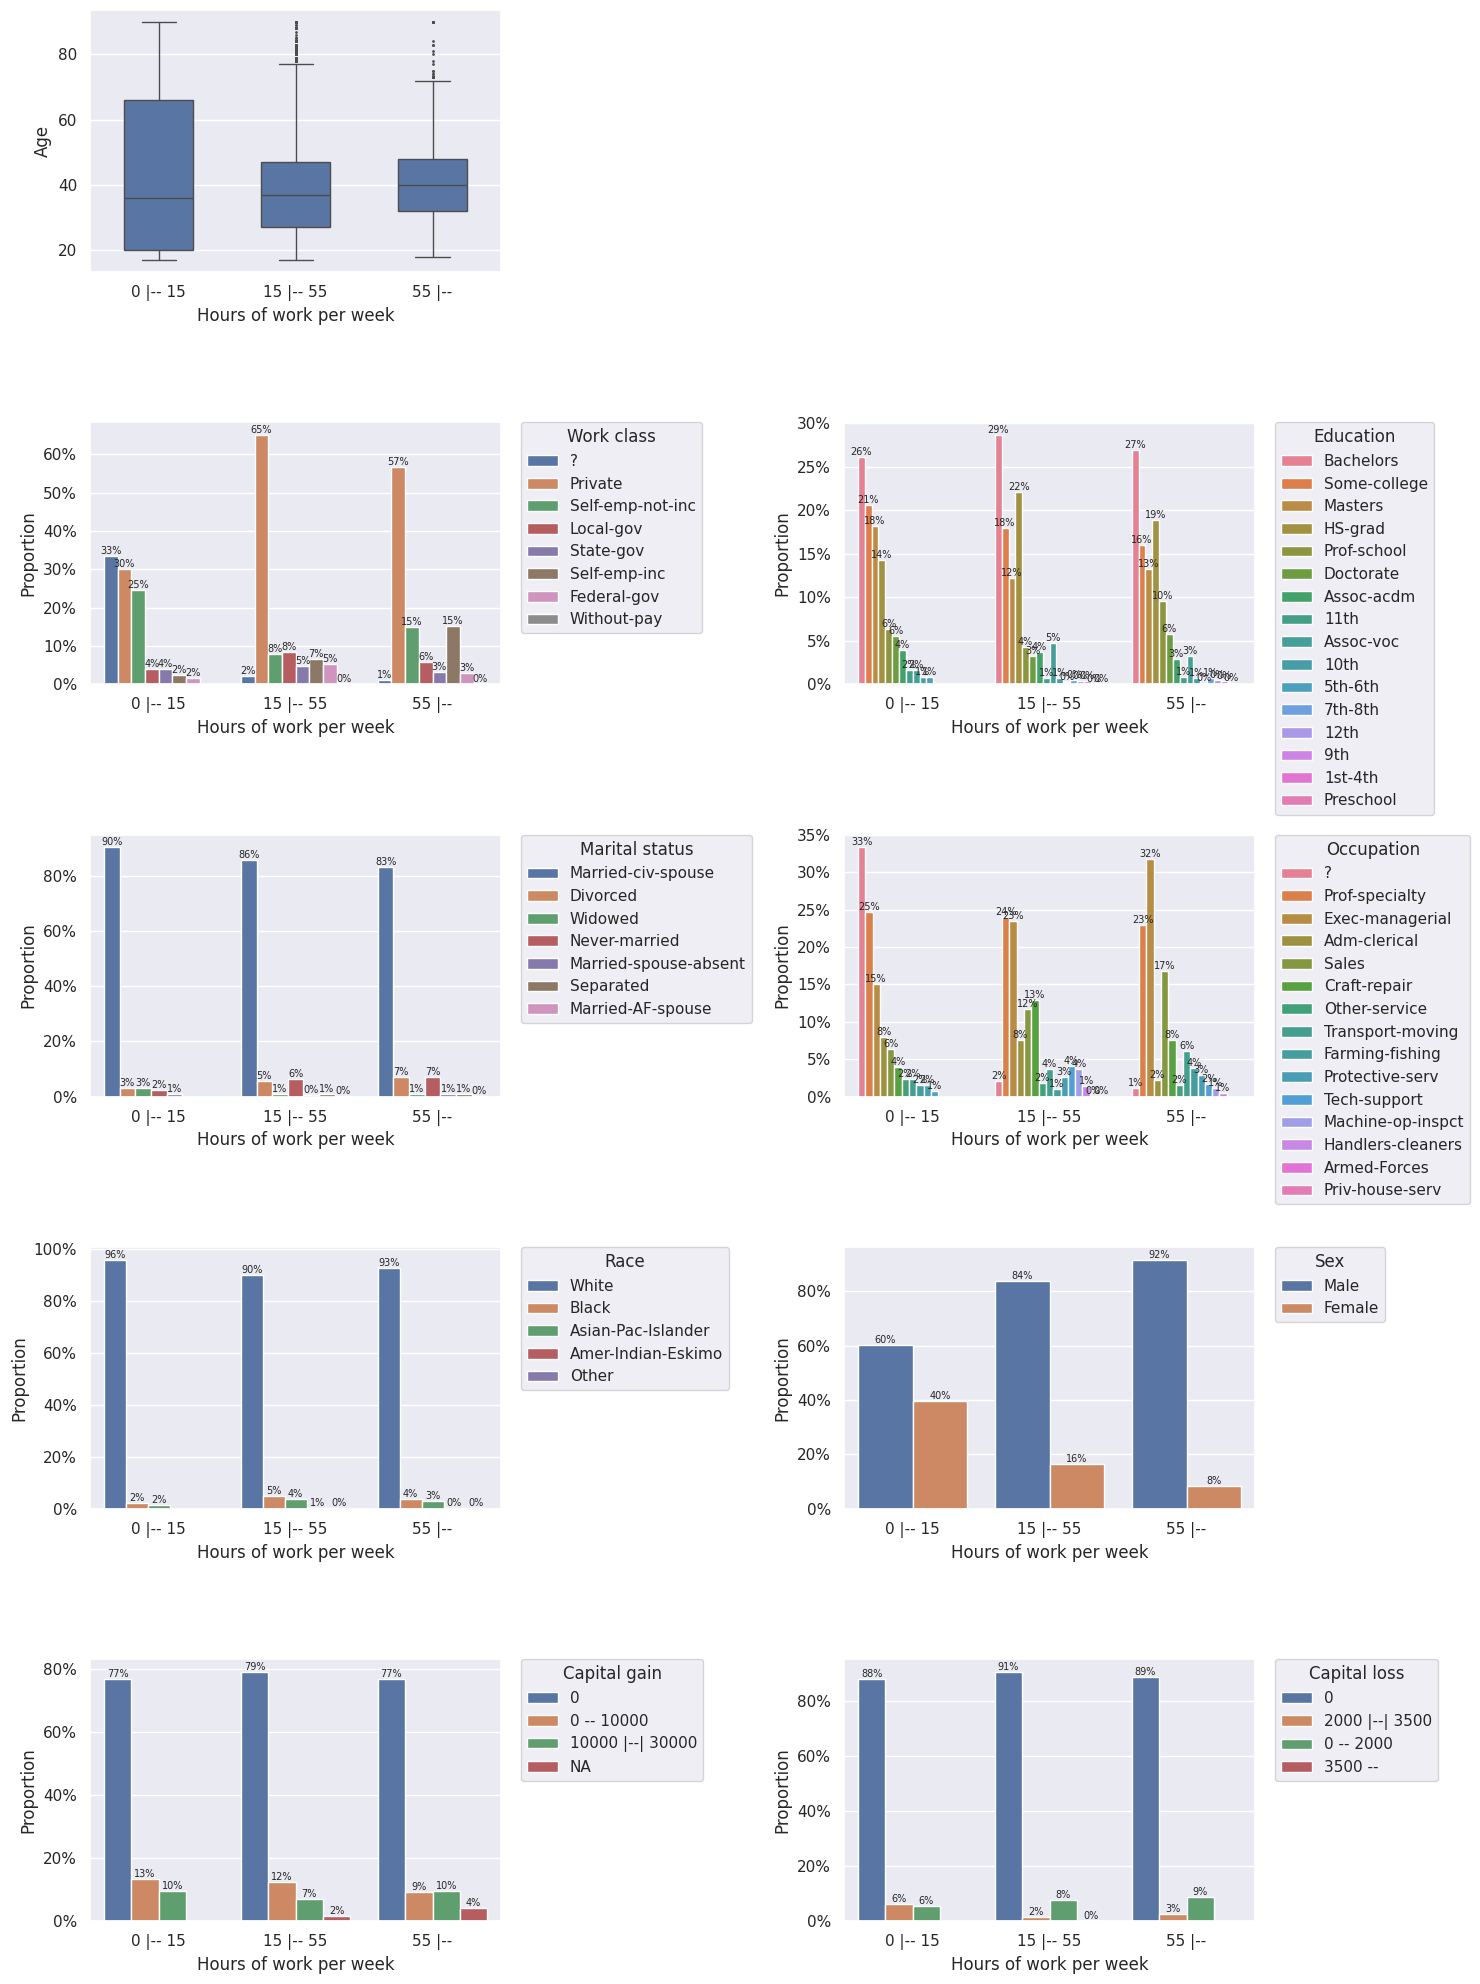

In [ ]:
df['hours.per.week.group'] = np.where(df['hours.per.week'] < 15, '0 |-- 15',
                             np.where(df['hours.per.week'] < 55, '15 |-- 55', '55 |--'))
hours_per_week_groups = ['0 |-- 15', '15 |-- 55', '55 |--']

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

# Age
sns.boxplot(data=df, x='hours.per.week.group', y='age', order=hours_per_week_groups, fliersize=1, width=0.5, ax=ax[0, 0])
ax[0, 0].set_xlabel('Hours of work per week')
ax[0, 0].set_ylabel('Age')

ax[0, 1].axis('off')

# Workclass
prop_workclass_by_hours = df.loc[df['income.gtr.50k'], :]\
                            .groupby('hours.per.week.group')['workclass']\
                            .value_counts(normalize=True)\
                            .to_frame()\
                            .rename(columns={'workclass': 'proportion'})\
                            .reset_index()
sns.barplot(data=prop_workclass_by_hours, x='hours.per.week.group', y='proportion', hue='workclass', ax=ax[1, 0])
for container in ax[1, 0].containers:
    ax[1, 0].bar_label(container, fmt=lambda x: f'{100*x:.0f}%', fontsize=7)
ax[1, 0].legend(title='Work class', loc='upper left', bbox_to_anchor=(1.03, 1.03))
ax[1, 0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
ax[1, 0].set_xlabel('Hours of work per week')
ax[1, 0].set_ylabel('Proportion')

# Education
prop_education_by_hours = df.loc[df['income.gtr.50k'], :]\
                            .groupby('hours.per.week.group')['education']\
                            .value_counts(normalize=True)\
                            .to_frame()\
                            .rename(columns={'education': 'proportion'})\
                            .reset_index()
sns.barplot(data=prop_education_by_hours, x='hours.per.week.group', y='proportion', hue='education', ax=ax[1, 1])
for container in ax[1, 1].containers:
    ax[1, 1].bar_label(container, fmt=lambda x: f'{100*x:.0f}%', fontsize=7)
ax[1, 1].legend(title='Education', loc='upper left', bbox_to_anchor=(1.03, 1.03))
ax[1, 1].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
ax[1, 1].set_xlabel('Hours of work per week')
ax[1, 1].set_ylabel('Proportion')

# Marital status
prop_marital_by_hours = df.loc[df['income.gtr.50k'], :]\
                          .groupby('hours.per.week.group')['marital.status']\
                          .value_counts(normalize=True)\
                          .to_frame()\
                          .rename(columns={'marital.status': 'proportion'})\
                          .reset_index()
sns.barplot(data=prop_marital_by_hours, x='hours.per.week.group', y='proportion', hue='marital.status', ax=ax[2, 0])
for container in ax[2, 0].containers:
    ax[2, 0].bar_label(container, fmt=lambda x: f'{100*x:.0f}%', fontsize=7)
ax[2, 0].legend(title='Marital status', loc='upper left', bbox_to_anchor=(1.03, 1.03))
ax[2, 0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
ax[2, 0].set_xlabel('Hours of work per week')
ax[2, 0].set_ylabel('Proportion')

# Occupation
prop_occupation_by_hours = df.loc[df['income.gtr.50k'], :]\
                             .groupby('hours.per.week.group')['occupation']\
                             .value_counts(normalize=True)\
                             .to_frame()\
                             .rename(columns={'occupation': 'proportion'})\
                             .reset_index()
sns.barplot(data=prop_occupation_by_hours, x='hours.per.week.group', y='proportion', hue='occupation', ax=ax[2, 1])
for container in ax[2, 1].containers:
    ax[2, 1].bar_label(container, fmt=lambda x: f'{100*x:.0f}%', fontsize=7)
ax[2, 1].legend(title='Occupation', loc='upper left', bbox_to_anchor=(1.03, 1.03))
ax[2, 1].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
ax[2, 1].set_xlabel('Hours of work per week')
ax[2, 1].set_ylabel('Proportion')

# Race
prop_race_by_hours = df.loc[df['income.gtr.50k'], :]\
                       .groupby('hours.per.week.group')['race']\
                       .value_counts(normalize=True)\
                       .to_frame()\
                       .rename(columns={'race': 'proportion'})\
                       .reset_index()
sns.barplot(data=prop_race_by_hours, x='hours.per.week.group', y='proportion', hue='race', ax=ax[3, 0])
for container in ax[3, 0].containers:
    ax[3, 0].bar_label(container, fmt=lambda x: f'{100*x:.0f}%', fontsize=7)
ax[3, 0].legend(title='Race', loc='upper left', bbox_to_anchor=(1.03, 1.03))
ax[3, 0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
ax[3, 0].set_xlabel('Hours of work per week')
ax[3, 0].set_ylabel('Proportion')

# Sex
prop_sex_by_hours = df.loc[df['income.gtr.50k'], :]\
                      .groupby('hours.per.week.group')['sex']\
                      .value_counts(normalize=True)\
                      .to_frame()\
                      .rename(columns={'sex': 'proportion'})\
                      .reset_index()
sns.barplot(data=prop_sex_by_hours, x='hours.per.week.group', y='proportion', hue='sex', ax=ax[3, 1])
for container in ax[3, 1].containers:
    ax[3, 1].bar_label(container, fmt=lambda x: f'{100*x:.0f}%', fontsize=7)
ax[3, 1].legend(title='Sex', loc='upper left', bbox_to_anchor=(1.03, 1.03))
ax[3, 1].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
ax[3, 1].set_xlabel('Hours of work per week')
ax[3, 1].set_ylabel('Proportion')

# Capital gain
prop_capital_gain_by_hours = df.loc[df['income.gtr.50k'], :]\
                               .groupby('hours.per.week.group')['capital.gain.group']\
                               .value_counts(normalize=True)\
                               .to_frame()\
                               .rename(columns={'capital.gain.group': 'proportion'})\
                               .reset_index()
sns.barplot(data=prop_capital_gain_by_hours, x='hours.per.week.group', y='proportion', hue='capital.gain.group', ax=ax[4, 0])
for container in ax[4, 0].containers:
    ax[4, 0].bar_label(container, fmt=lambda x: f'{100*x:.0f}%', fontsize=7)
ax[4, 0].legend(title='Capital gain', loc='upper left', bbox_to_anchor=(1.03, 1.03))
ax[4, 0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
ax[4, 0].set_xlabel('Hours of work per week')
ax[4, 0].set_ylabel('Proportion')

# Capital loss
prop_capital_loss_by_hours = df.loc[df['income.gtr.50k'], :]\
                            .groupby('hours.per.week.group')['capital.loss.group']\
                            .value_counts(normalize=True)\
                            .to_frame()\
                            .rename(columns={'capital.loss.group': 'proportion'})\
                            .reset_index()
sns.barplot(data=prop_capital_loss_by_hours, x='hours.per.week.group', y='proportion', hue='capital.loss.group', ax=ax[4, 1])
for container in ax[4, 1].containers:
    ax[4, 1].bar_label(container, fmt=lambda x: f'{100*x:.0f}%', fontsize=7)
ax[4, 1].legend(title='Capital loss', loc='upper left', bbox_to_anchor=(1.03, 1.03))
ax[4, 1].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
ax[4, 1].set_xlabel('Hours of work per week')
ax[4, 1].set_ylabel('Proportion')

plt.tight_layout()
plt.show()

## 2.14. Native country

There are 42 distinct values in the `native.country` column, including "?" and names of American territories.

In [ ]:
countries = df['native.country'].unique()
countries.sort()
print(f"{df['native.country'].nunique()} countries: {countries}")

42 countries: ['?' 'Cambodia' 'Canada' 'China' 'Columbia' 'Cuba' 'Dominican-Republic'
 'Ecuador' 'El-Salvador' 'England' 'France' 'Germany' 'Greece' 'Guatemala'
 'Haiti' 'Holand-Netherlands' 'Honduras' 'Hong' 'Hungary' 'India' 'Iran'
 'Ireland' 'Italy' 'Jamaica' 'Japan' 'Laos' 'Mexico' 'Nicaragua'
 'Outlying-US(Guam-USVI-etc)' 'Peru' 'Philippines' 'Poland' 'Portugal'
 'Puerto-Rico' 'Scotland' 'South' 'Taiwan' 'Thailand' 'Trinadad&Tobago'
 'United-States' 'Vietnam' 'Yugoslavia']


The name "South" above is ambiguous, as there are three countries whose names begin with this word: South Africa, South Sudan and South Korea. However, when we inspect the `race` variable for these records, we conclude that it actually means "South Korea".

In [ ]:
df[df['native.country'] == "South"]['race'].value_counts()

Asian-Pac-Islander    110
Amer-Indian-Eskimo      2
White                   1
Other                   1
Black                   1
Name: race, dtype: int64

The column `native.country.edited` contains the corrected version of the names in the column `native.country`.

In [ ]:
df['native.country.edited'] = df['native.country'].replace({'Columbia': 'Colombia',
                                                            'Dominican-Republic': 'Dominican Republic',
                                                            'El-Salvador': 'El Salvador',
                                                            'Holand-Netherlands': 'Netherlands',
                                                            'Hong': 'Hong Kong',
                                                            'Outlying-US(Guam-USVI-etc)': 'Outlying US (Guam, USVI etc.)',
                                                            'Puerto-Rico': 'Puerto Rico',
                                                            'South': 'South Korea',
                                                            'Trinadad&Tobago': 'Trinidad and Tobago',
                                                            'United-States': 'United States',
                                                            '?': 'unknown'
                                                           })

As expected, the most frequent country of origin is the United States, which could represent an even larger figure if we also take its territories into account. Other relatively common countries are Mexico, the Philippines and Germany, for example. Interestingly, all the countries lie at least partially in the northern hemisphere. Besides, some continents, like Africa and Oceania, have no records, which indicates that the sample is probably not random.

In [ ]:
income_by_country = df.groupby('native.country.edited')\
                      .agg({'income.gtr.50k': 'mean', 'native.country.edited': 'count'})\
                      .rename(columns={'native.country.edited': 'count'})\
                      .reset_index()\
                      .sort_values('count', ascending=False)
income_by_country

,native.country.edited,income.gtr.50k,count
38,United States,0.243977,43832
24,Mexico,0.049422,951
41,unknown,0.256709,857
29,Philippines,0.288136,295
10,Germany,0.281553,206
32,Puerto Rico,0.108696,184
1,Canada,0.346154,182
7,El Salvador,0.070968,155
17,India,0.410596,151
4,Cuba,0.246377,138


The map below depicts the proportion of people whose annual income is greater than USD 50K according to their countries of origin. We can identify that the proportion of people with high income is generally greater in Europe, followed by Asia and then America (except the USA and Canada). By the way, the last one is more homogeneous than the other two. Although Canada and the USA are both situated in North America, we would rather not group them because the USA is the country where the survey was carried out, and thus has a different status compared with the other nation.

In [ ]:
country_codes = pd.read_excel(project_folder + '/Country codes.xlsx')
country_codes.head()
income_by_country = income_by_country.merge(country_codes, how='left', left_on='native.country.edited', right_on='country_name')
income_by_iso = income_by_country.groupby('iso_alpha').apply(lambda x: np.average(x['income.gtr.50k'], weights=x['count']))

fig = px.choropleth(locations=income_by_iso.index, color=income_by_iso.values,
                    color_continuous_scale='bluered_r',
                    title='Income by country of origin',
                    labels={'color': 'Proportion of income > USD 50K/year'})
fig.show()

Based on the results above, we will create seven groups of countries:
- America (not US/Canada): Colombia, Cuba, Dominican Republic, Ecuador, El Salvador, Guatemala, Haiti, Honduras, Jamaica, Mexico, Nicaragua, Peru, Puerto Rico, and Trinidad and Tobago.
- Asia 1: Cambodia, China, India, Iran, Japan and Taiwan.
- Asia 2: Hong Kong, Laos, Philippines, South Korea, Thailand and Vietnam.
- Europe 1: England, France, Greece, Hungary, Italy, Yugoslavia, Ireland and Germany.
- Europe 2: Netherlands, Poland, Portugal and Scotland.
- Canada.
- Others.

In [ ]:
country_groups = {'US': ['United States'],
                  'America': ['Colombia', 'Cuba', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Guatemala', 'Haiti',
                              'Honduras', 'Jamaica', 'Mexico', 'Nicaragua', 'Peru', 'Puerto Rico', 'Trinidad and Tobago'],
                  'Asia 1': ['Cambodia', 'China', 'India', 'Iran', 'Japan', 'Taiwan'],
                  'Asia 2': ['Hong Kong', 'Laos', 'Philippines', 'South Korea', 'Thailand', 'Vietnam'],
                  'Europe 1': ['England', 'France', 'Greece', 'Hungary', 'Italy', 'Yugoslavia', 'Ireland', 'Germany'],
                  'Europe 2': ['Netherlands', 'Poland', 'Portugal', 'Scotland'],
                  'Canada': ['Canada'],
                  'Others': ['Outlying US (Guam, USVI etc.)', 'unknown']}

country_groups = {country: group for group in country_groups for country in country_groups[group]}

df['country.group'] = df['native.country.edited'].map(country_groups)

# 3. Inferential Analysis

In this section we will demonstrate some classification methods that could be used to predict whether a person has high income.

We will apply the following classification algorithms:
- Logistic regression
- Naïve Bayes
- K nearest neighbors
- Support vector machine
- Random forest

Each algorithm will be assessed using the following measures:
- accuracy: the proportion of true results (both true positives and true negatives) in the sample
 $$ \text{accuracy} = \frac{TP + TN}{TP + TN + FP + FN} $$
where:
    - TP = True Positives
    - TN = True Negatives
    - FP = False Positives
    - FN = False Negatives

- precision: the ratio of true positive outcomes to all positive predictions
$$ \text{precision} = \frac{TP}{TP + FP} $$

- recall (or sensitivity): the ratio of true positive outcomes to all actual positives
$$ \text{recall} = \frac{TP}{TP + FN} $$

- F1-score: the harmonic mean of precision and recall, providing a balance between the two for uneven class distributions.
$$ \text{F1-score} = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}} $$

- ROC AUC ("ROC" = "receiver operating characteristic", "AUC" = "area under the curve"): the ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings and shows the trade-off between the two rates. The AUC can be defined as

$$ AUC = \int_{x=0}^1 ROC(x) dx $$

and corresponds to the blue area in the plot below.

<center><img src="https://drive.google.com/uc?export=view&id=1xhL_mLIEg2kBQI-YvdGUJopX3lhJO3En"/></center>

<font size=2><center> Source: https://en.wikipedia.org/wiki/File:Basic_AUC_annotated.png.</center></font>

Taking into account that the measures are defined with respect to different subsamples, it follows naturally that, for algorithms that output a probability (instead of a yes/no answer), the measures behave differently for each probability threshold above which we consider an observation to be positive. In addition, each measure exhibits its maximal value for a different probability threshold. Extreme cases are precision and recall. With the threshold = 0, for example, precision = 0

## 3.1. Data preparation

In [ ]:
df['workclass_regrouped'] = np.where(df['workclass'].isin(['Never-worked', 'Without-pay', '?']), 'Others', df['workclass'])

In [ ]:
df['education_regrouped'] = np.where(df['education'].isin(['Preschool', '1st-4th', '5th-6th', '7th-8th',
                                                           '9th', '10th', '11th', '12th']),
                                     'Others', df['education'])

Before the classification algorithms, we need to arrange the data in such a way that scikit-learn classes can use them. More precisely, we will create dummy columns to encode categorical features, standardise numerical features, and split up the dataset into train and test data.

In [ ]:
workclass_dummies = pd.get_dummies(df['workclass_regrouped'], drop_first=True)
education_dummies = pd.get_dummies(df['education_regrouped'], drop_first=True)
marital_status_dummies = pd.get_dummies(df['marital.status'], drop_first=True)
occupation_dummies = pd.get_dummies(df['occupation'], drop_first=True)
race_dummies = pd.get_dummies(df['race'], drop_first=True)
sex_dummies = pd.get_dummies(df['sex'], drop_first=True)
country_group_dummies = pd.get_dummies(df['country.group'], drop_first=True)
capital_gain_group_dummies = pd.get_dummies(df['capital.gain.group'], drop_first=True)
capital_loss_group_dummies = pd.get_dummies(df['capital.loss.group'], drop_first=True)
hours_per_week_group_dummies = pd.get_dummies(df['hours.per.week.group'], drop_first=True)

columns_to_keep = ['age', 'age.power.2', 'education.num', 'capital.gain','capital.gain.na', 'capital.loss', 'hours.per.week']

X = pd.concat([df[columns_to_keep], workclass_dummies, education_dummies, marital_status_dummies, occupation_dummies,
               race_dummies, sex_dummies, country_group_dummies, capital_gain_group_dummies,
               capital_loss_group_dummies, hours_per_week_group_dummies], axis=1)

standard_scaler = StandardScaler()

y = df['income.gtr.50k']

X_train, X_test, y_train, y_test = train_test_split(X, y)

standard_scaler.fit(X_train)
X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

## 3.2. Classification algorithms

### 3.2.1. Logistic regression

In a logistic regression model, we fit the data to the following equation:
$$ P(E \mid x_1, ..., x_k) = \frac{1}{1 + e^{-(\beta_0 + \sum_{i=1}^k \beta_i x_i)}}, $$
where
- $E$ is the event of interest,
- $x_1, ..., x_k$ are the observed values of the independent (or explaining) variables,
- $P(E \mid x_1, ..., x_k)$ is the probability that the event of interest occurs given $x_1$, ..., $x_k$,
- $\beta_0$ is the intercept coefficient, and
- $\beta_1, ..., \beta_k$ are the coefficients associated with each independent variable.

Note that, with the transformation $y = \log\frac{p}{1-p}$, where $p = P(E \mid x_1, ..., x_k)$, we can rewrite the equation above as a linear regression model:
$$ \log \frac{p}{1-p} = \beta_0 + \sum_{i=1}^k \beta_i x_i.$$

The coefficients in the equation above are estimated by minimizing the cost function

$$ J(\beta) = \frac{1}{n} \left[ \sum_{i=1}^n -y_i \log(\hat{y}_i) + (1-y_i) \log (1-\hat{y}_i) \right] + \frac{1}{2C}\lVert \beta \rVert^2, $$

where
- $y_i$ = 1 if the event occurred for the $i$-th sample unit and 0 otherwise,
- $\hat{y}_i$ is the estimated probability for the event using the values of independent variables of the $i$-th sample unit and $\beta_0, ..., \beta_k$, and
- $C$ is the regularization parameter, which prevents overfitting by increasing the penalty for larger coefficient estimates (the lower $C$ is, the higher the penalty).

Once the model is fitted, we are able to estimate the probability of income > USD 50K/year. Nonetheless, the prediction as to whether the income is (or is not) greater than USD 50K/year depends on the threshold that we set. Estimated probability values above this cutoff will be considered as a positive prediction of the event of interest. Thus, besides the model hyperparameters, we may also select an optimal threshold, which yields the best value of the performance measure.

In [ ]:
lr = LogisticRegression()

param_grid = {'penalty': ['l2'],               # Type of norm of the penalty
              'C': np.logspace(-3, 3, 7),      # Inverse of regularization strength.
                                               # Smaller values specify stronger regularization.
              'solver': ['newton-cholesky']    # Algorithm to use in the optimization problem.
}

gscv_lr = GridSearchCV(estimator=lr, param_grid=param_grid)

gscv_lr.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l2'], 'solver': ['newton-cholesky']})

In our case, we have tried 7 different values ($10^{-3}$, $10^{-2}$, ..., $10^3$) for $C$ and found out that $C = 1$ gives the best score (more precisely, the best accuracy).

In [ ]:
gscv_lr.best_params_

{'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cholesky'}

In [ ]:
gscv_lr.best_score_

0.8597909906631076

It is clear below that different measures show different results as to which might be the best threshold. For instance, 86.24% of the guesses are correct when we consider that an individual has high income if the respective probability is at least 50%. However, the recall is best for threshold = 20% (among the considered values).

In [ ]:
lr = LogisticRegression(C=gscv_lr.best_params_['C'],
                        penalty=gscv_lr.best_params_['penalty'],
                        solver=gscv_lr.best_params_['solver'])
lr.fit(X_train, y_train)

prediction_lr_prob = lr.predict_proba(X_test)

thresholds = np.arange(0.2, 0.8, 0.1)

accuracy_summary  = 'accuracy ................ '
f1_summary        = 'f1 ...................... '
precision_summary = 'precision ............... '
recall_summary    = 'recall .................. '
roc_auc_summary   = 'ROC AUC .......... '

for threshold in thresholds:
    prediction_lr = prediction_lr_prob[:, 1] >= threshold
    accuracy_summary = accuracy_summary + f'| {accuracy_score(y_test, prediction_lr):.4f} '
    f1_summary = f1_summary + f'| {f1_score(y_test, prediction_lr):.4f} '
    precision_summary = precision_summary + f'| {precision_score(y_test, prediction_lr):.4f} '
    recall_summary = recall_summary + f'| {recall_score(y_test, prediction_lr):.4f} '

roc_auc_summary = roc_auc_summary + f'{roc_auc_score(y_test, prediction_lr_prob[:, 1]):.4f}'

print('Score        threshold -> |  0.2   |  0.3   |  0.4   |  0.5   |  0.6   |  0.7   |  0.8  ')
print('----------------------------------------------------------------------------------------')
print(accuracy_summary)
print(f1_summary)
print(precision_summary)
print(recall_summary)
print(roc_auc_summary)

Score        threshold -> |  0.2   |  0.3   |  0.4   |  0.5   |  0.6   |  0.7   |  0.8  
----------------------------------------------------------------------------------------
accuracy ................ | 0.7997 | 0.8383 | 0.8553 | 0.8624 | 0.8572 | 0.8481 | 0.8315 
f1 ...................... | 0.6776 | 0.7039 | 0.6989 | 0.6789 | 0.6319 | 0.5640 | 0.4632 
precision ............... | 0.5479 | 0.6218 | 0.6896 | 0.7599 | 0.8123 | 0.8824 | 0.9457 
recall .................. | 0.8877 | 0.8111 | 0.7085 | 0.6135 | 0.5171 | 0.4145 | 0.3067 
ROC AUC .......... 0.9162 |


### 3.2.2. Naïve Bayes

The Naïve Bayes algorithm is based on Bayes' theorem:
$$ P(c \mid x)= \frac{P(x∣c) \cdot P(c)}{P(x)} $$
where
- $P(c \mid x)$ is the posterior probability of class $c$ given predictor $x$,
- $P(x \mid c)$ is the likelihood, the probability of predictor $x$ given class $c$,
- $P(c)$ is the prior probability of class $c$, and
- $P(x)$ is the prior probability of predictor $x$.

The algorithm is called "naïve" because it assumes that the features are conditionally independent given the class $c$, that is,

$$ P\left(x_1, ..., x_k \mid c\right) = P(c) \prod_{i=1}^k P(x_i \mid c) $$

where $k$ is the number of features in $x$.

The algorithm calculates the probability of each class based on the input features. The predicted class, $\hat{y}$ is the class $c$ that maximizes the probability above, that is,

$$ \hat{y} = \arg \max_c P(c) \prod_{i=1}^k P(x_i \mid c)$$

Despite its simplicity and efficiency, Naïve Bayes may not perform as well as more complex algorithms when the independence assumption does not hold true for the data.

In [ ]:
gnb = GaussianNB()

gnb.fit(X_train, y_train)

prediction_gnb_prob = gnb.predict_proba(X_test)

In [ ]:
thresholds = np.arange(0.2, 0.8, 0.1)

accuracy_summary  = 'accuracy ................ '
f1_summary        = 'f1 ...................... '
precision_summary = 'precision ............... '
recall_summary    = 'recall .................. '
roc_auc_summary   = 'ROC AUC .......... '

for threshold in thresholds:
    prediction_gnb = prediction_gnb_prob[:, 1] >= threshold
    accuracy_summary = accuracy_summary + f'| {accuracy_score(y_test, prediction_gnb):.4f} '
    f1_summary = f1_summary + f'| {f1_score(y_test, prediction_gnb):.4f} '
    precision_summary = precision_summary + f'| {precision_score(y_test, prediction_gnb):.4f} '
    recall_summary = recall_summary + f'| {recall_score(y_test, prediction_gnb):.4f} '

roc_auc_summary = roc_auc_summary + f'{roc_auc_score(y_test, prediction_gnb_prob[:, 1]):.4f}'

print('Score        threshold -> |  0.2   |  0.3   |  0.4   |  0.5   |  0.6   |  0.7   |  0.8  ')
print('----------------------------------------------------------------------------------------')
print(accuracy_summary)
print(f1_summary)
print(precision_summary)
print(recall_summary)
print(roc_auc_summary)

Score        threshold -> |  0.2   |  0.3   |  0.4   |  0.5   |  0.6   |  0.7   |  0.8  
----------------------------------------------------------------------------------------
accuracy ................ | 0.8143 | 0.8161 | 0.8162 | 0.8172 | 0.8181 | 0.8185 | 0.8184 
f1 ...................... | 0.6169 | 0.6137 | 0.6092 | 0.6061 | 0.6030 | 0.5981 | 0.5921 
precision ............... | 0.6036 | 0.6112 | 0.6143 | 0.6196 | 0.6248 | 0.6296 | 0.6331 
recall .................. | 0.6307 | 0.6162 | 0.6041 | 0.5931 | 0.5827 | 0.5696 | 0.5561 
ROC AUC .......... 0.9162 |


### 3.2.3. K Nearest Neighbors

The K Nearest Neighbors (KNN) algorithm is based on the idea that data points in the same category of the target variable are close to each other in the feature space.

For classification, KNN works by finding the K nearest data points (neighbors) to the new data point that needs to be classified. The class of the majority of these K neighbors is assigned to the new data point.

Alternatively, we could consider a probabilistic approach by calculating the proportion of each class among the nearest neighbors of the new point. This way, if the estimated probability of belonging to a certain class is higher than or equal to a predefined threshold, we assign that class to the new point. This is is the method we adopt in the following simulation.

KNN is a non-parametric, lazy learning algorithm, which means that it does not make any assumptions about the underlying data distribution and does not require training before making predictions.

One of the key hyperparameters in KNN is the value of K, which determines the number of neighbors to consider. Choosing the right value of K is crucial, as a small K can lead to overfitting, while a large K can lead to underfitting.

In [ ]:
knn = KNeighborsClassifier()

We will try 1, 2, 3, 4, 5, 7, 10, 15, 20, 25 and 30 as possible values for K.

In [ ]:
param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30]}   # Number of neighbors to use

gscv_knn = GridSearchCV(estimator=knn, param_grid=param_grid)

gscv_knn.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30]})

The grid search algorithm finds the best K = 25 neighbors.

In [ ]:
gscv_knn.best_params_

{'n_neighbors': 25}

In [ ]:
gscv_knn.best_score_

0.835358054929503

Accuracy, F1-score, precision and recall for different thresholds, as well as ROC AUC, are shown below.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=gscv_knn.best_params_['n_neighbors'])
knn.fit(X_train, y_train)

prediction_knn_prob = knn.predict_proba(X_test)

thresholds = np.arange(0.2, 0.8, 0.1)

accuracy_summary  = 'accuracy ................ '
f1_summary        = 'f1 ...................... '
precision_summary = 'precision ............... '
recall_summary    = 'recall .................. '
roc_auc_summary   = 'ROC AUC .......... '

for threshold in thresholds:
    prediction_knn = prediction_knn_prob[:, 1] >= threshold
    accuracy_summary = accuracy_summary + f'| {accuracy_score(y_test, prediction_knn):.4f} '
    f1_summary = f1_summary + f'| {f1_score(y_test, prediction_knn):.4f} '
    precision_summary = precision_summary + f'| {precision_score(y_test, prediction_knn):.4f} '
    recall_summary = recall_summary + f'| {recall_score(y_test, prediction_knn):.4f} '

roc_auc_summary = roc_auc_summary + f'{roc_auc_score(y_test, prediction_knn_prob[:, 1]):.4f}'

print('Score        threshold -> |  0.2   |  0.3   |  0.4   |  0.5   |  0.6   |  0.7   |  0.8  ')
print('----------------------------------------------------------------------------------------')
print(accuracy_summary)
print(f1_summary)
print(precision_summary)
print(recall_summary)
print(roc_auc_summary)

Score        threshold -> |  0.2   |  0.3   |  0.4   |  0.5   |  0.6   |  0.7   |  0.8  
----------------------------------------------------------------------------------------
accuracy ................ | 0.7375 | 0.8030 | 0.8281 | 0.8315 | 0.8253 | 0.8173 | 0.8015 
f1 ...................... | 0.6238 | 0.6590 | 0.6480 | 0.6179 | 0.5263 | 0.4570 | 0.3337 
precision ............... | 0.4784 | 0.5683 | 0.6444 | 0.6878 | 0.7705 | 0.8208 | 0.9019 
recall .................. | 0.8961 | 0.7841 | 0.6516 | 0.5609 | 0.3997 | 0.3167 | 0.2047 
ROC AUC .......... 0.8805


### 3.2.4. Support Vector Machine

Support Vector Machine (SVM) finds the hyperplane that best separates different classes in the feature space while maximizing the margin between the classes.

SVM finds the hyperplane that maximizes the margin between the nearest data points of different classes (support vectors). The hyperplane is defined by the equation $w\cdot x + b = 0$, where $w$ is the weight vector, $x$ is the input vector, and $b$ is the bias.

For classification, SVM predicts the class of a new data point by checking which side of the hyperplane it falls on.

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
svc = SVC(kernel='linear', verbose=True)

In [ ]:
n_train = X_train.shape[0]
sample = random.sample(range(n_train), round(n_train * 0.5))
X_train_sample = X_train[sample, :]
y_train_sample = y_train.values[sample]

We will try out different variables for the regularization parameter $C$. The higher the value of $C$, the more accurately the algorithm tries to fit the training data, potentially reducing the margin between classes.

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100]}   # The strength of the regularization is inversely proportional to C.

gscv_svc = GridSearchCV(estimator=svc, param_grid=param_grid)

gscv_svc.fit(X_train_sample, y_train_sample)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

GridSearchCV(estimator=SVC(kernel='linear', verbose=True),
             param_grid={'C': [0.1, 1, 10, 100]})

The best hyperparameter, according to the grid search, was $C = 100$.

In [68]:
gscv_svc.best_params_

{'C': 100}

Accuracy, F1-score, precision and recall are shown below.

In [63]:
svc = LinearSVC(C=gscv_svc.best_params_['C'])

svc.fit(X_train, y_train)

prediction_svc = svc.predict(X_test)

accuracy_summary  = 'accuracy score:   ' + f'{accuracy_score(y_test, prediction_svc):.4f}'
f1_summary        = 'f1 score:         ' + f'{f1_score(y_test, prediction_svc):.4f}'
precision_summary = 'precision score:  ' + f'{precision_score(y_test, prediction_svc):.4f}'
recall_summary    = 'recall score:     ' + f'{recall_score(y_test, prediction_svc):.4f}'

print(accuracy_summary)
print(f1_summary)
print(precision_summary)
print(recall_summary)

accuracy score:   0.8156
f1 score:         0.6213
precision score:  0.6046
recall score:     0.6389


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



### 3.2.5. Random forest

Random Forest is an ensemble learning method that builds multiple decision trees during training and outputs the mode (for classification) or the average prediction (for regression) of the individual trees.

Each tree is trained on a subset of the training data (bootstrap sample) and a subset of the features (randomly selected) to ensure diversity among the trees. They are trained using the CART (Classification and Regression Trees) algorithm, which recursively splits the data based on features to minimize impurity (e.g., Gini impurity for classification, mean squared error for regression).

Random Forest reduces overfitting by averaging multiple decision trees.
It can handle large datasets with high dimensionality and provides an estimate of feature importance.

In [64]:
rfc = RandomForestClassifier()

In [65]:
param_grid = {'n_estimators': [50, 100, 200, 400, 800, 1600],   # Number of trees in the random forest
              'max_features': ['sqrt', 'log2'],                 # Number of features to consider at every split
              'max_depth': [10, 20, 40, 80],                    # Maximum number of levels in tree
              'min_samples_split': [2, 4, 8],                   # Minimum number of samples required to split a node
              'min_samples_leaf': [1, 2, 4],                    # Minimum number of samples required at each leaf node
              'bootstrap': [True, False]                        # Method of selecting samples for training each tree
}

gscv_rfc = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid, n_iter=30, cv=3, verbose=2)

gscv_rfc.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   1.8s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   2.5s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   1.7s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total 

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=30,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 40, 80],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 8],
                                        'n_estimators': [50, 100, 200, 400, 800,
                                                         1600]},
                   verbose=2)

The grid search cross-validation has selected the following set of best hyperparameters:
- `n_estimators` = 50 estimators (number of trees)
- `min_samples_split` = 2 samples required to split a node
- `min_samples_leaf` = 4 samples at least at each leaf node
- each tree is allowed to try the square root of the total number of features (`max_features`)
- each tree can have a maximum depth of `max_depth` = 80
- samples for each tree will be selected by a bootstrap (`= True`) re-sampling method, in such a way that different trees are estimated based on different subsamples of the whole data set.

In [67]:
gscv_rfc.best_params_

{'n_estimators': 50,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

Accuracy, F1-score, precision and recall are shown below.

In [66]:
rfc = RandomForestClassifier(n_estimators=gscv_rfc.best_params_['n_estimators'],
                             max_features=gscv_rfc.best_params_['max_features'],
                             max_depth=gscv_rfc.best_params_['max_depth'],
                             min_samples_split=gscv_rfc.best_params_['min_samples_split'],
                             min_samples_leaf=gscv_rfc.best_params_['min_samples_leaf'],
                             bootstrap=gscv_rfc.best_params_['bootstrap'])

rfc.fit(X_train, y_train)

prediction_rfc = rfc.predict(X_test)

accuracy_summary  = 'accuracy score:   ' + f'{accuracy_score(y_test, prediction_rfc):.4f}'
f1_summary        = 'f1 score:         ' + f'{f1_score(y_test, prediction_rfc):.4f}'
precision_summary = 'precision score:  ' + f'{precision_score(y_test, prediction_rfc):.4f}'
recall_summary    = 'recall score:     ' + f'{recall_score(y_test, prediction_rfc):.4f}'

print(accuracy_summary)
print(f1_summary)
print(precision_summary)
print(recall_summary)

accuracy score:   0.8657
f1 score:         0.6809
precision score:  0.7781
recall score:     0.6053


### 3.2.6. Comparison of algorithms

Among the multiple possible ways of comparing the five just explained algorithms, we have decided to use F1-score as it is available for all of them and is a compromise between precision and recall. For algorithms whose results depend on the probability threshold, we will pick the best F1-score.
The following table ranks the models above.

<center>

Algorithm | (Best) F1-score
--- | ---:
Logistic Regression | 0.7039
Random Forest | 0.6809
K Nearest Neighbors | 0.6590
Support Vector Machine | 0.6213
Naïve Bayes | 0.6169

</center>

In this particular scenario, logistic regression turns out to be best choice, whereas Naïve Bayes is the worst one (not surprisingly, since the independence assumption hardly holds for the analysed data).

Yet we have to remark that the mentioned result can change for the same data set if we come up with different groupings and auxiliary features.